# CNN-Based Seismic Risk Zone Classification

This notebook trains Convolutional Neural Networks (CNNs) to classify spatial regions as high-risk or low-risk for seismic activity.

## Task Overview

**Input:** 32×32 spatial grids with 2 channels:
- Channel 1: Earthquake density (count per grid cell)
- Channel 2: Average magnitude per grid cell

**Output:** Binary classification
- Class 0: Low-risk zone (magnitude < 4.5)
- Class 1: High-risk zone (magnitude ≥ 4.5)

**Why CNNs?**
- Excel at spatial pattern recognition
- Can detect regional seismic activity patterns
- Learn local features (hotspots) and global patterns (fault lines)

## Models

We'll train 3 CNN architectures:
1. **Shallow CNN** - 2 conv layers (baseline)
2. **Standard CNN** - 4 conv layers (main model)
3. **Deep CNN** - 6 conv layers with residual connections

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')
from models.cnn import SeismicRiskCNN, SeismicRiskCNN_Shallow, SeismicRiskCNN_Deep

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Load and Prepare Data

In [2]:
# Load CNN grid data
print("Loading CNN grid data...")
X_train = np.load('../data/processed/model_ready/X_train_cnn.npy')
X_val = np.load('../data/processed/model_ready/X_val_cnn.npy')
X_test = np.load('../data/processed/model_ready/X_test_cnn.npy')

# Load magnitude targets
y_train_mag = np.load('../data/processed/model_ready/y_train_cnn.npy')
y_val_mag = np.load('../data/processed/model_ready/y_val_cnn.npy')
y_test_mag = np.load('../data/processed/model_ready/y_test_cnn.npy')

print(f"\nData shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")
print(f"\nTarget shapes:")
print(f"  y_train: {y_train_mag.shape}")
print(f"  y_val: {y_val_mag.shape}")
print(f"  y_test: {y_test_mag.shape}")

Loading CNN grid data...

Data shapes:
  X_train: (3958, 32, 32, 2)
  X_val: (859, 32, 32, 2)
  X_test: (860, 32, 32, 2)

Target shapes:
  y_train: (3958,)
  y_val: (859,)
  y_test: (860,)


In [3]:
# Convert magnitude targets to binary risk classification
# High-risk: magnitude >= 4.5 (significant earthquakes that can cause damage)
# Low-risk: magnitude < 4.5 (minor earthquakes)
RISK_THRESHOLD = 4.5

y_train = (y_train_mag >= RISK_THRESHOLD).astype(np.int64)
y_val = (y_val_mag >= RISK_THRESHOLD).astype(np.int64)
y_test = (y_test_mag >= RISK_THRESHOLD).astype(np.int64)

print(f"\nRisk Classification (threshold = {RISK_THRESHOLD}):")
print(f"\nTraining set:")
print(f"  Low-risk (0): {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  High-risk (1): {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")

print(f"\nValidation set:")
print(f"  Low-risk (0): {(y_val == 0).sum()} ({(y_val == 0).mean()*100:.1f}%)")
print(f"  High-risk (1): {(y_val == 1).sum()} ({(y_val == 1).mean()*100:.1f}%)")

print(f"\nTest set:")
print(f"  Low-risk (0): {(y_test == 0).sum()} ({(y_test == 0).mean()*100:.1f}%)")
print(f"  High-risk (1): {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")


Risk Classification (threshold = 4.5):

Training set:
  Low-risk (0): 3599 (90.9%)
  High-risk (1): 359 (9.1%)

Validation set:
  Low-risk (0): 797 (92.8%)
  High-risk (1): 62 (7.2%)

Test set:
  Low-risk (0): 776 (90.2%)
  High-risk (1): 84 (9.8%)


In [4]:
# Transpose to PyTorch format: (batch, height, width, channels) -> (batch, channels, height, width)
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_val = np.transpose(X_val, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

print(f"\nAfter transpose to PyTorch format (batch, channels, height, width):")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")


After transpose to PyTorch format (batch, channels, height, width):
  X_train: (3958, 2, 32, 32)
  X_val: (859, 2, 32, 32)
  X_test: (860, 2, 32, 32)


In [5]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

print(f"\nConverted to PyTorch tensors:")
print(f"  X_train: {X_train_tensor.shape}, dtype: {X_train_tensor.dtype}")
print(f"  y_train: {y_train_tensor.shape}, dtype: {y_train_tensor.dtype}")


Converted to PyTorch tensors:
  X_train: torch.Size([3958, 2, 32, 32]), dtype: torch.float32
  y_train: torch.Size([3958]), dtype: torch.int64


In [6]:
# Create DataLoaders
batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


DataLoaders created:
  Train batches: 62
  Val batches: 14
  Test batches: 14


## 2. Visualize Sample Grids

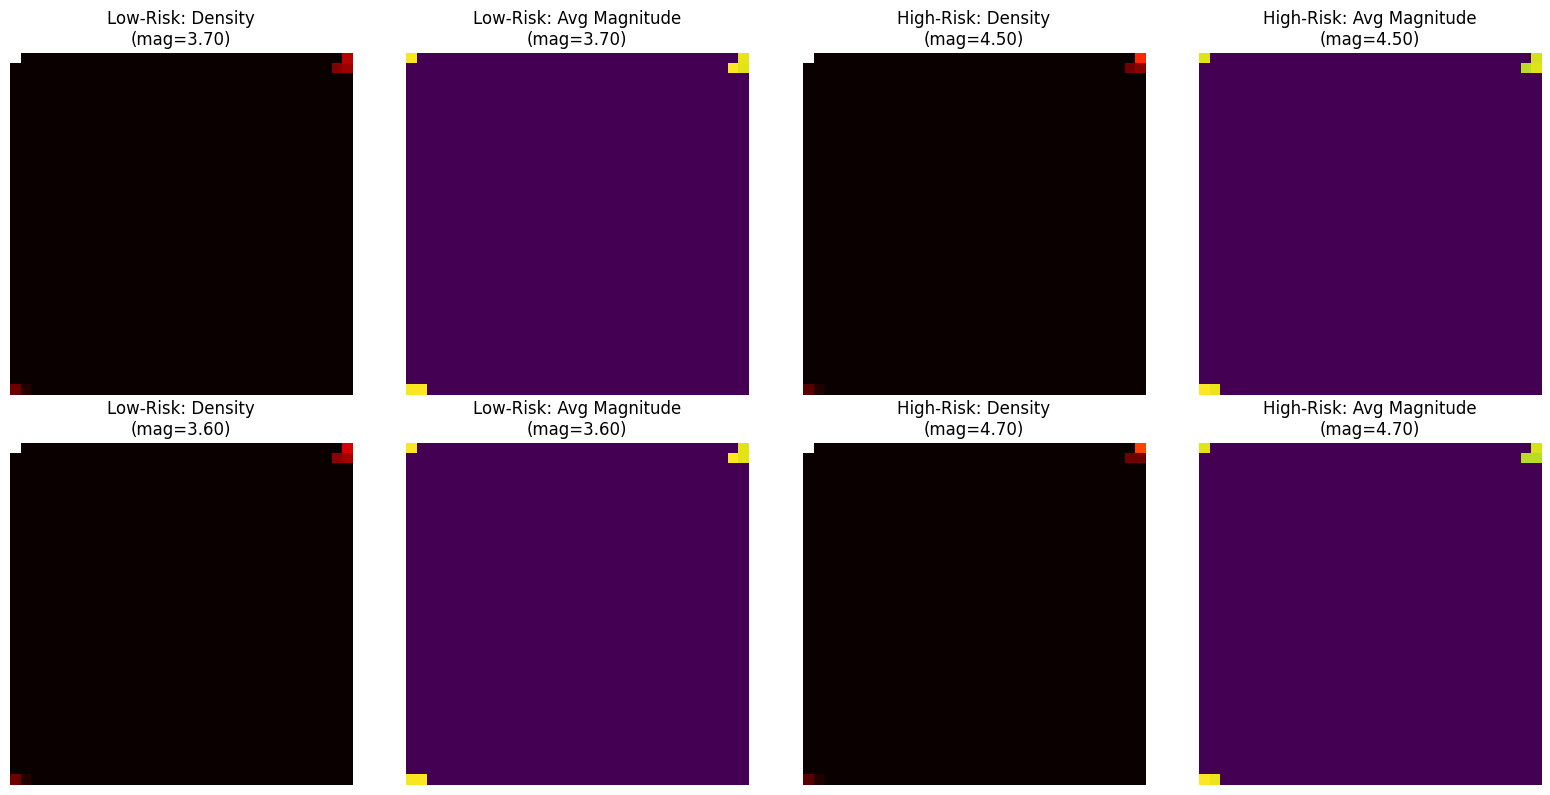

Sample grids visualized successfully!


In [8]:
# Visualize sample grids from both classes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Low-risk samples
low_risk_idx = np.where(y_train == 0)[0][:2]
for i, idx in enumerate(low_risk_idx):
    # Density channel
    axes[i, 0].imshow(X_train[idx, 0], cmap='hot')
    axes[i, 0].set_title(f'Low-Risk: Density\n(mag={y_train_mag[idx]:.2f})')
    axes[i, 0].axis('off')
    
    # Magnitude channel
    axes[i, 1].imshow(X_train[idx, 1], cmap='viridis')
    axes[i, 1].set_title(f'Low-Risk: Avg Magnitude\n(mag={y_train_mag[idx]:.2f})')
    axes[i, 1].axis('off')

# High-risk samples
high_risk_idx = np.where(y_train == 1)[0][:2]
for i, idx in enumerate(high_risk_idx):
    # Density channel
    axes[i, 2].imshow(X_train[idx, 0], cmap='hot')
    axes[i, 2].set_title(f'High-Risk: Density\n(mag={y_train_mag[idx]:.2f})')
    axes[i, 2].axis('off')
    
    # Magnitude channel
    axes[i, 3].imshow(X_train[idx, 1], cmap='viridis')
    axes[i, 3].set_title(f'High-Risk: Avg Magnitude\n(mag={y_train_mag[idx]:.2f})')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig('../results/visualizations/cnn/sample_grids.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample grids visualized successfully!")

## 3. Training Function

In [9]:
def train_cnn_model(model, train_loader, val_loader, criterion, optimizer, 
                    num_epochs=100, patience=15, model_name='CNN'):
    """
    Train CNN model with early stopping.
    
    Args:
        model: CNN model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        num_epochs: Maximum number of epochs
        patience: Early stopping patience
        model_name: Name for saving/logging
    
    Returns:
        model: Trained model
        history: Training history
    """
    model = model.to(device)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    
    print(f"\nTraining {model_name}...")
    print("="*70)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_x.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        train_loss /= train_total
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item() * batch_x.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        # Early stopping
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Restore best model
    model.load_state_dict(best_model_state)
    print(f"\nBest validation loss: {best_val_loss:.4f}")
    print("="*70)
    
    return model, history

## 4. Evaluation Function

In [10]:
def evaluate_model(model, test_loader, model_name='CNN'):
    """
    Evaluate model on test set.
    
    Args:
        model: Trained model
        test_loader: Test data loader
        model_name: Model name for display
    
    Returns:
        results: Dictionary with evaluation metrics
    """
    model.eval()
    model = model.to(device)
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    roc_auc = roc_auc_score(all_labels, all_probs)
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }
    
    # Print results
    print(f"\n{model_name} Test Results:")
    print("="*50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print("="*50)
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_preds, 
                                target_names=['Low-Risk', 'High-Risk']))
    
    return results

## 5. Calculate Class Weights for Imbalanced Data

In [11]:
# Calculate class weights to handle imbalance
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"Class distribution in training set:")
print(f"  Class 0 (Low-risk): {class_counts[0]} samples")
print(f"  Class 1 (High-risk): {class_counts[1]} samples")
print(f"\nClass weights: {class_weights}")

Class distribution in training set:
  Class 0 (Low-risk): 3599 samples
  Class 1 (High-risk): 359 samples

Class weights: tensor([0.0907, 0.9093])


## 6. Train Model 1: Shallow CNN

In [12]:
# Initialize model
model_shallow = SeismicRiskCNN_Shallow(in_channels=2, num_classes=2, dropout=0.25)
print(f"\nShallow CNN Architecture:")
print(model_shallow)
print(f"\nTotal parameters: {sum(p.numel() for p in model_shallow.parameters()):,}")


Shallow CNN Architecture:
SeismicRiskCNN_Shallow(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

Total parameters: 1,068,642


In [13]:
# Training configuration
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_shallow.parameters(), lr=0.001, weight_decay=1e-5)

# Train
model_shallow, history_shallow = train_cnn_model(
    model_shallow, train_loader, val_loader, criterion, optimizer,
    num_epochs=100, patience=15, model_name='Shallow CNN'
)


Training Shallow CNN...
Epoch [  1/100] | Train Loss: 30.0046 | Train Acc: 0.5076 | Val Loss: 4.1062 | Val Acc: 0.5180
Epoch [ 10/100] | Train Loss: 0.7449 | Train Acc: 0.8775 | Val Loss: 0.6904 | Val Acc: 0.9278
Epoch [ 20/100] | Train Loss: 0.7019 | Train Acc: 0.7582 | Val Loss: 0.6871 | Val Acc: 0.9278
Epoch [ 30/100] | Train Loss: 0.6945 | Train Acc: 0.9035 | Val Loss: 0.6869 | Val Acc: 0.9278
Epoch [ 40/100] | Train Loss: 0.6929 | Train Acc: 0.9088 | Val Loss: 0.6884 | Val Acc: 0.9278

Early stopping at epoch 48

Best validation loss: 0.6853


In [14]:
# Evaluate
results_shallow = evaluate_model(model_shallow, test_loader, model_name='Shallow CNN')


Shallow CNN Test Results:
Accuracy:  0.9023
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
ROC-AUC:   0.5043

Classification Report:
              precision    recall  f1-score   support

    Low-Risk       0.90      1.00      0.95       776
   High-Risk       0.00      0.00      0.00        84

    accuracy                           0.90       860
   macro avg       0.45      0.50      0.47       860
weighted avg       0.81      0.90      0.86       860



## 7. Train Model 2: Standard CNN

In [15]:
# Initialize model
model_standard = SeismicRiskCNN(in_channels=2, num_classes=2, dropout=0.3)
print(f"\nStandard CNN Architecture:")
print(model_standard)
print(f"\nTotal parameters: {sum(p.numel() for p in model_standard.parameters()):,}")


Standard CNN Architecture:
SeismicRiskCNN(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_si

In [16]:
# Training configuration
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_standard.parameters(), lr=0.001, weight_decay=1e-5)

# Train
model_standard, history_standard = train_cnn_model(
    model_standard, train_loader, val_loader, criterion, optimizer,
    num_epochs=100, patience=15, model_name='Standard CNN'
)


Training Standard CNN...
Epoch [  1/100] | Train Loss: 3.2628 | Train Acc: 0.4550 | Val Loss: 1.5627 | Val Acc: 0.9278
Epoch [ 10/100] | Train Loss: 1.3975 | Train Acc: 0.5417 | Val Loss: 0.6829 | Val Acc: 0.9278
Epoch [ 20/100] | Train Loss: 1.1796 | Train Acc: 0.4977 | Val Loss: 0.7267 | Val Acc: 0.0722
Epoch [ 30/100] | Train Loss: 0.9214 | Train Acc: 0.5422 | Val Loss: 0.6767 | Val Acc: 0.9278

Early stopping at epoch 33

Best validation loss: 0.6752


In [17]:
# Evaluate
results_standard = evaluate_model(model_standard, test_loader, model_name='Standard CNN')


Standard CNN Test Results:
Accuracy:  0.1616
Precision: 0.1004
Recall:    0.9524
F1 Score:  0.1816
ROC-AUC:   0.4373

Classification Report:
              precision    recall  f1-score   support

    Low-Risk       0.94      0.08      0.14       776
   High-Risk       0.10      0.95      0.18        84

    accuracy                           0.16       860
   macro avg       0.52      0.51      0.16       860
weighted avg       0.85      0.16      0.14       860



## 8. Train Model 3: Deep CNN

In [18]:
# Initialize model
model_deep = SeismicRiskCNN_Deep(in_channels=2, num_classes=2, dropout=0.35)
print(f"\nDeep CNN Architecture:")
print(model_deep)
print(f"\nTotal parameters: {sum(p.numel() for p in model_deep.parameters()):,}")


Deep CNN Architecture:
SeismicRiskCNN_Deep(
  (conv_init): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_init): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1a): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2b): BatchNorm2d(128, eps=1e-05, momentu

In [19]:
# Training configuration
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_deep.parameters(), lr=0.0005, weight_decay=1e-5)  # Lower LR for deeper model

# Train
model_deep, history_deep = train_cnn_model(
    model_deep, train_loader, val_loader, criterion, optimizer,
    num_epochs=100, patience=20, model_name='Deep CNN'
)


Training Deep CNN...
Epoch [  1/100] | Train Loss: 6.8887 | Train Acc: 0.4368 | Val Loss: 5.3815 | Val Acc: 0.0722
Epoch [ 10/100] | Train Loss: 2.7791 | Train Acc: 0.5328 | Val Loss: 0.6815 | Val Acc: 0.9115
Epoch [ 20/100] | Train Loss: 1.8018 | Train Acc: 0.5374 | Val Loss: 0.6741 | Val Acc: 0.9278
Epoch [ 30/100] | Train Loss: 1.8155 | Train Acc: 0.4997 | Val Loss: 0.6870 | Val Acc: 0.8964
Epoch [ 40/100] | Train Loss: 1.2418 | Train Acc: 0.5374 | Val Loss: 0.6735 | Val Acc: 0.9278
Epoch [ 50/100] | Train Loss: 1.0010 | Train Acc: 0.5083 | Val Loss: 0.6773 | Val Acc: 0.9278

Early stopping at epoch 53

Best validation loss: 0.6729


In [20]:
# Evaluate
results_deep = evaluate_model(model_deep, test_loader, model_name='Deep CNN')


Deep CNN Test Results:
Accuracy:  0.8849
Precision: 0.0588
Recall:    0.0119
F1 Score:  0.0198
ROC-AUC:   0.5100

Classification Report:
              precision    recall  f1-score   support

    Low-Risk       0.90      0.98      0.94       776
   High-Risk       0.06      0.01      0.02        84

    accuracy                           0.88       860
   macro avg       0.48      0.50      0.48       860
weighted avg       0.82      0.88      0.85       860



## 9. Compare All Models

In [21]:
import pandas as pd

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': results_shallow['model_name'],
        'Accuracy': results_shallow['accuracy'],
        'Precision': results_shallow['precision'],
        'Recall': results_shallow['recall'],
        'F1': results_shallow['f1'],
        'ROC-AUC': results_shallow['roc_auc']
    },
    {
        'Model': results_standard['model_name'],
        'Accuracy': results_standard['accuracy'],
        'Precision': results_standard['precision'],
        'Recall': results_standard['recall'],
        'F1': results_standard['f1'],
        'ROC-AUC': results_standard['roc_auc']
    },
    {
        'Model': results_deep['model_name'],
        'Accuracy': results_deep['accuracy'],
        'Precision': results_deep['precision'],
        'Recall': results_deep['recall'],
        'F1': results_deep['f1'],
        'ROC-AUC': results_deep['roc_auc']
    }
])

print("\n" + "="*80)
print("MODEL COMPARISON - CNN SEISMIC RISK CLASSIFICATION")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Save results
comparison_df.to_csv('../results/visualizations/cnn/model_comparison.csv', index=False)
print("\nResults saved to: ../results/visualizations/cnn/model_comparison.csv")


MODEL COMPARISON - CNN SEISMIC RISK CLASSIFICATION
       Model  Accuracy  Precision   Recall       F1  ROC-AUC
 Shallow CNN  0.902326   0.000000 0.000000 0.000000 0.504326
Standard CNN  0.161628   0.100376 0.952381 0.181612 0.437308
    Deep CNN  0.884884   0.058824 0.011905 0.019802 0.510033

Results saved to: ../results/visualizations/cnn/model_comparison.csv


## 10. Visualize Training History

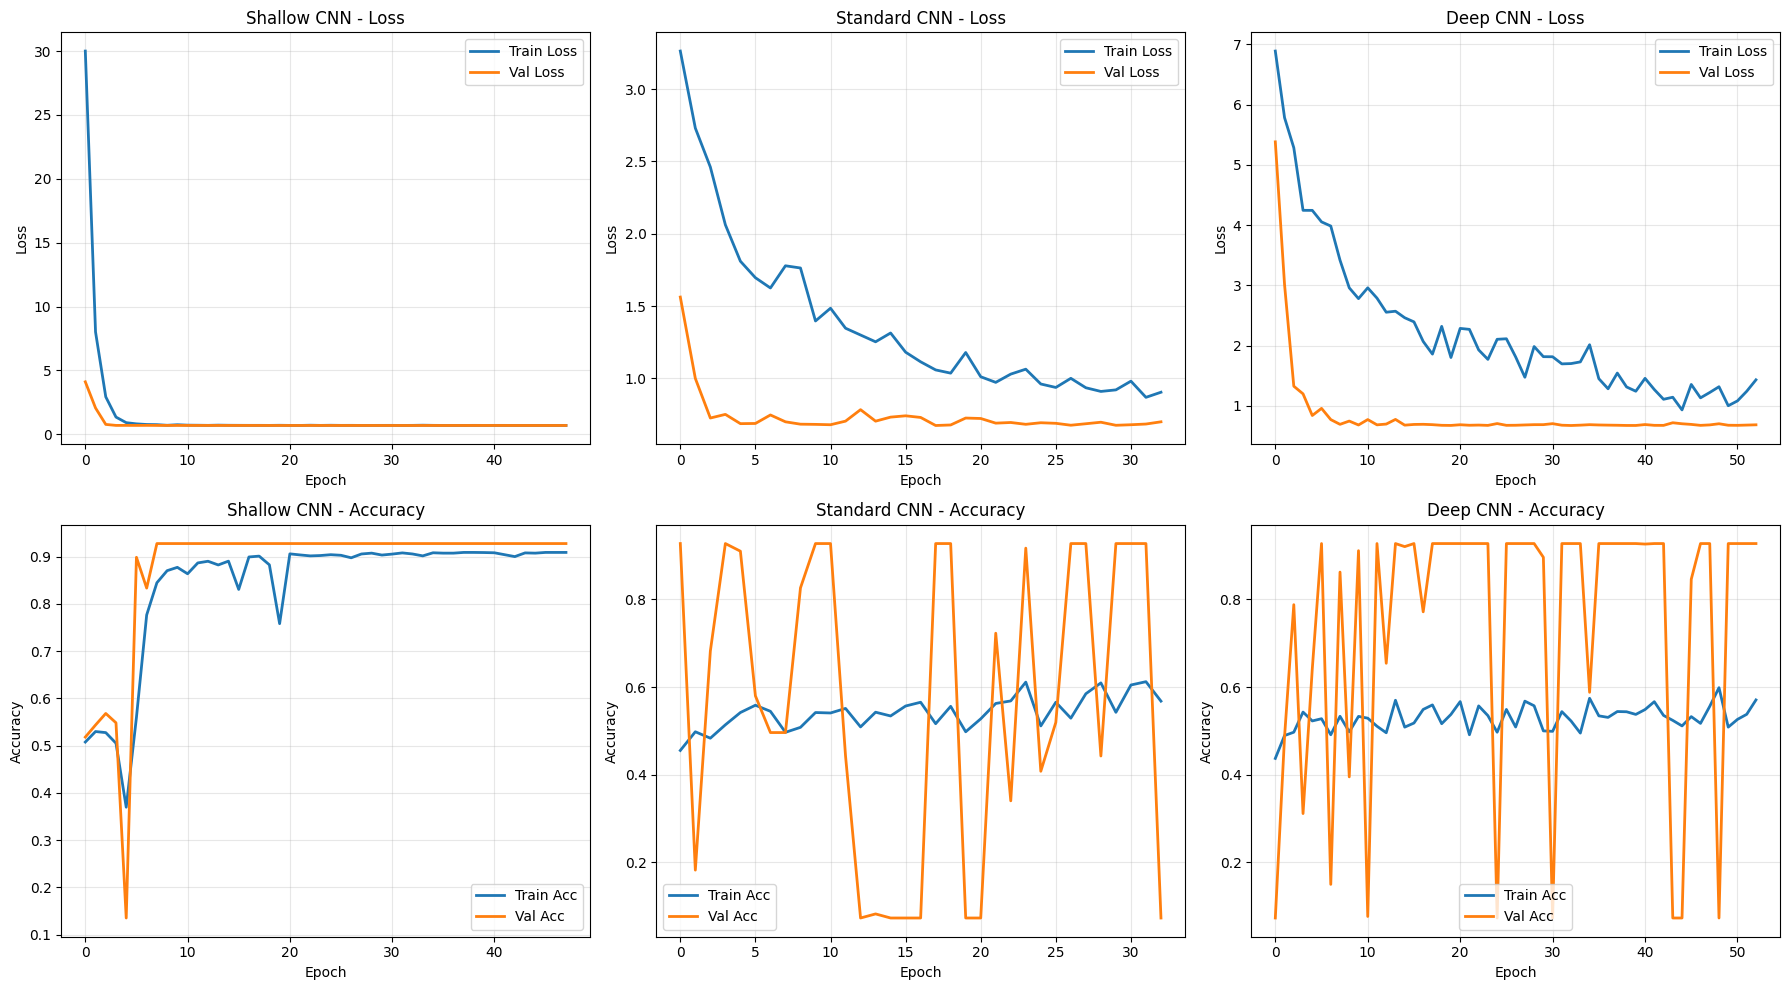

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histories = [
    (history_shallow, 'Shallow CNN'),
    (history_standard, 'Standard CNN'),
    (history_deep, 'Deep CNN')
]

for idx, (history, name) in enumerate(histories):
    # Loss plot
    axes[0, idx].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, idx].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Loss')
    axes[0, idx].set_title(f'{name} - Loss')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[1, idx].plot(history['train_acc'], label='Train Acc', linewidth=2)
    axes[1, idx].plot(history['val_acc'], label='Val Acc', linewidth=2)
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Accuracy')
    axes[1, idx].set_title(f'{name} - Accuracy')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/cnn/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Confusion Matrices

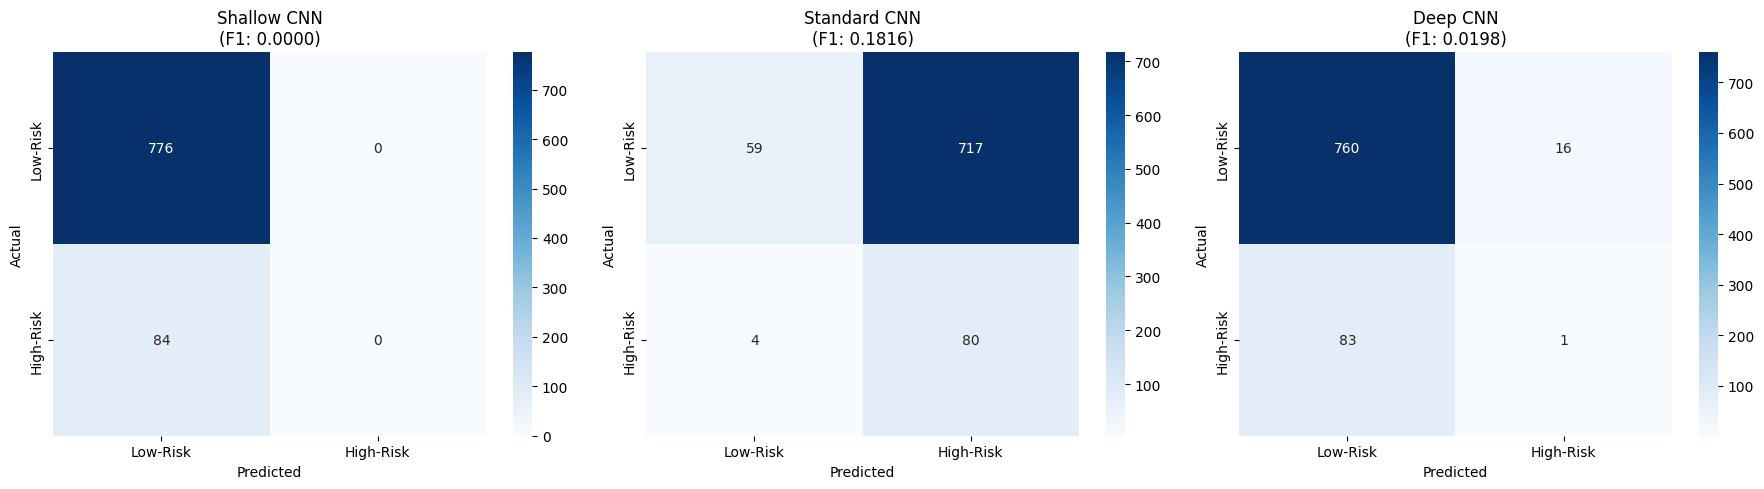

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

results_list = [results_shallow, results_standard, results_deep]

for idx, results in enumerate(results_list):
    cm = confusion_matrix(results['labels'], results['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Low-Risk', 'High-Risk'],
                yticklabels=['Low-Risk', 'High-Risk'])
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f"{results['model_name']}\n(F1: {results['f1']:.4f})")

plt.tight_layout()
plt.savefig('../results/visualizations/cnn/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. ROC Curves

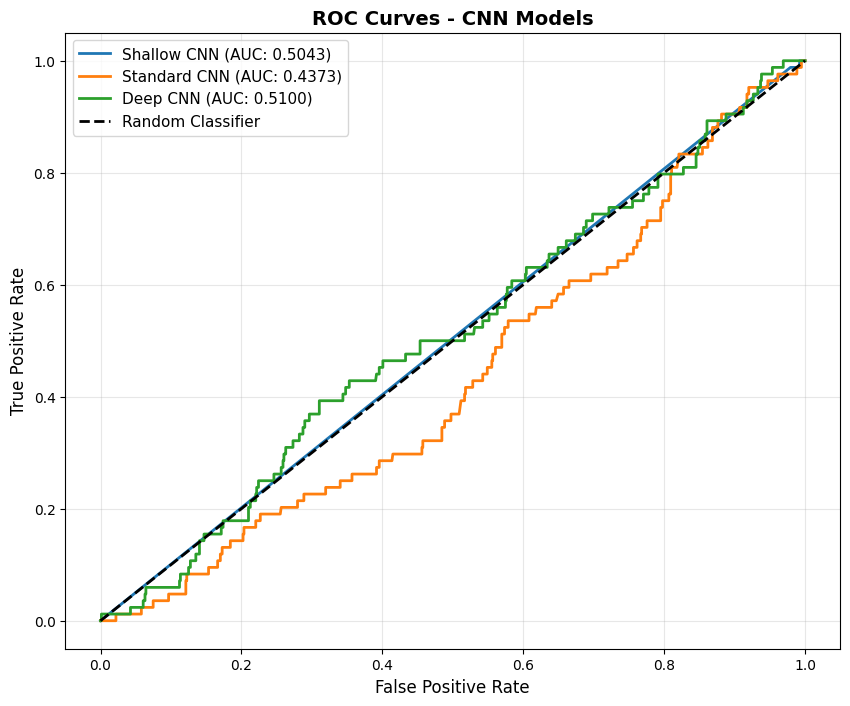

In [24]:
plt.figure(figsize=(10, 8))

for results in results_list:
    fpr, tpr, _ = roc_curve(results['labels'], results['probabilities'])
    plt.plot(fpr, tpr, linewidth=2, 
             label=f"{results['model_name']} (AUC: {results['roc_auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - CNN Models', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.savefig('../results/visualizations/cnn/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Model Comparison Bar Chart

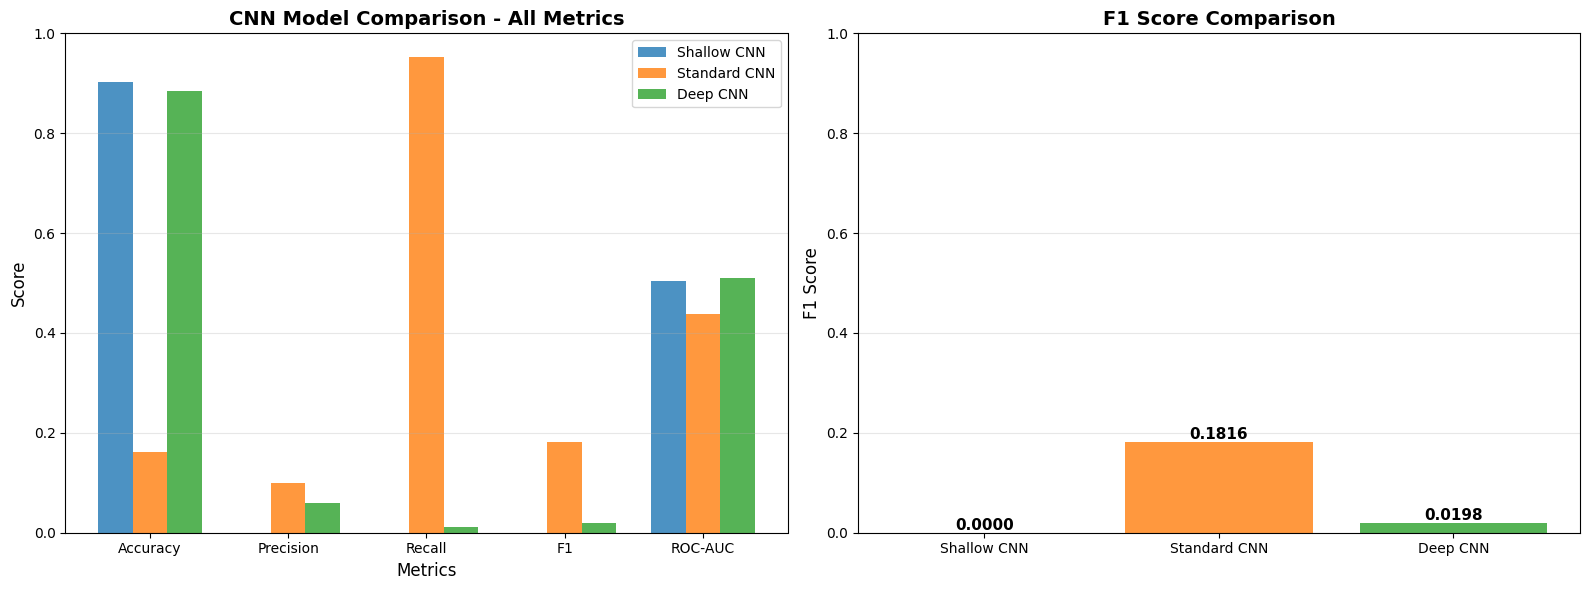

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25

# Bar chart
shallow_scores = [results_shallow['accuracy'], results_shallow['precision'], 
                  results_shallow['recall'], results_shallow['f1'], results_shallow['roc_auc']]
standard_scores = [results_standard['accuracy'], results_standard['precision'], 
                   results_standard['recall'], results_standard['f1'], results_standard['roc_auc']]
deep_scores = [results_deep['accuracy'], results_deep['precision'], 
               results_deep['recall'], results_deep['f1'], results_deep['roc_auc']]

axes[0].bar(x - width, shallow_scores, width, label='Shallow CNN', alpha=0.8)
axes[0].bar(x, standard_scores, width, label='Standard CNN', alpha=0.8)
axes[0].bar(x + width, deep_scores, width, label='Deep CNN', alpha=0.8)

axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('CNN Model Comparison - All Metrics', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.0])

# F1 Score comparison
models = ['Shallow CNN', 'Standard CNN', 'Deep CNN']
f1_scores = [results_shallow['f1'], results_standard['f1'], results_deep['f1']]

bars = axes[1].bar(models, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 1.0])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/visualizations/cnn/model_comparison_chart.png', dpi=150, bbox_inches='tight')
plt.show()

## 14. Save Models and Results

In [26]:
import pickle
import os

# Create output directory
os.makedirs('../models/saved/cnn_risk', exist_ok=True)

# Save models
torch.save(model_shallow.state_dict(), '../models/saved/cnn_risk/shallow_cnn.pt')
torch.save(model_standard.state_dict(), '../models/saved/cnn_risk/standard_cnn.pt')
torch.save(model_deep.state_dict(), '../models/saved/cnn_risk/deep_cnn.pt')

# Save test results
results_dict = {
    'shallow': results_shallow,
    'standard': results_standard,
    'deep': results_deep,
    'comparison_df': comparison_df
}

with open('../results/visualizations/cnn/test_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print("\n" + "="*70)
print("Models and results saved successfully!")
print("="*70)
print("\nSaved files:")
print("  Models: ../models/saved/cnn_risk/")
print("  Results: ../results/visualizations/cnn/test_results.pkl")
print("  Comparison: ../results/visualizations/cnn/model_comparison.csv")


Models and results saved successfully!

Saved files:
  Models: ../models/saved/cnn_risk/
  Results: ../results/visualizations/cnn/test_results.pkl
  Comparison: ../results/visualizations/cnn/model_comparison.csv


## 15. Summary and Key Findings

In [27]:
print("\n" + "="*80)
print("CNN SEISMIC RISK CLASSIFICATION - SUMMARY")
print("="*80)

print("\n📊 TASK: Binary classification of seismic risk zones")
print(f"   - Input: 32×32 spatial grids (2 channels: density + avg magnitude)")
print(f"   - Output: Low-risk (mag < {RISK_THRESHOLD}) vs High-risk (mag >= {RISK_THRESHOLD})")
print(f"   - Training samples: {len(y_train)}")
print(f"   - Test samples: {len(y_test)}")

print("\n🏆 BEST MODEL:")
best_idx = comparison_df['F1'].idxmax()
best_model = comparison_df.iloc[best_idx]
print(f"   Model: {best_model['Model']}")
print(f"   F1 Score: {best_model['F1']:.4f}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")

print("\n📈 MODEL RANKING (by F1 Score):")
ranked = comparison_df.sort_values('F1', ascending=False)
for i, row in ranked.iterrows():
    print(f"   {i+1}. {row['Model']:20s} - F1: {row['F1']:.4f}")

print("\n💡 KEY INSIGHTS:")
print("   - CNNs learn spatial patterns in earthquake distribution")
print("   - 2D convolutions capture local seismic hotspots and regional trends")
print("   - Model architecture (shallow vs deep) impacts performance")
print("   - Useful for regional risk assessment and planning")

print("\n🔍 COMPARISON WITH OTHER APPROACHES:")
print("   - DNN: Uses tabular features (no spatial structure)")
print("   - CNN: Uses spatial grid patterns (fixed grid structure)")
print("   - GNN: Uses graph structure (flexible spatial relationships)")

print("\n" + "="*80)
print("Training complete! Check ../results/visualizations/cnn/ for all plots.")
print("="*80)


CNN SEISMIC RISK CLASSIFICATION - SUMMARY

📊 TASK: Binary classification of seismic risk zones
   - Input: 32×32 spatial grids (2 channels: density + avg magnitude)
   - Output: Low-risk (mag < 4.5) vs High-risk (mag >= 4.5)
   - Training samples: 3958
   - Test samples: 860

🏆 BEST MODEL:
   Model: Standard CNN
   F1 Score: 0.1816
   Accuracy: 0.1616
   ROC-AUC: 0.4373

📈 MODEL RANKING (by F1 Score):
   2. Standard CNN         - F1: 0.1816
   3. Deep CNN             - F1: 0.0198
   1. Shallow CNN          - F1: 0.0000

💡 KEY INSIGHTS:
   - CNNs learn spatial patterns in earthquake distribution
   - 2D convolutions capture local seismic hotspots and regional trends
   - Model architecture (shallow vs deep) impacts performance
   - Useful for regional risk assessment and planning

🔍 COMPARISON WITH OTHER APPROACHES:
   - DNN: Uses tabular features (no spatial structure)
   - CNN: Uses spatial grid patterns (fixed grid structure)
   - GNN: Uses graph structure (flexible spatial relation